In [1]:
import datetime
import pandas as pd
from pprint import pprint
from sidecar import Sidecar
from ipyleaflet import Map, basemaps, DrawControl, TileLayer, LayersControl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self,eeImageObject, visParams, name):
    mapID = ee.Image(eeImageObject).getMapId(visParams)
    tiles = TileLayer(
        url = mapID['tile_fetcher'].url_format,
        attribution="Map Data © <a href=’https://earthengine.google.com’>Google Earth Engine</a>",
        name = name,
    )
    self.add_layer(tiles)
    
Map.add_ee_layer = add_ee_layer

In [3]:
m = Map(center=(0,35),zoom=8,basemap=basemaps.CartoDB.Positron)
m.scroll_wheel_zoom = True

draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "I'm sorry Dave, I'm afraid I can't do that"
    },
    "allowIntersection": False
}
draw_control.circle = {
    "shapeOptions": {
        "fillColor": "#efed69",
        "color": "#efed69",
        "fillOpacity": 1.0
    }
}
draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m.add_control(LayersControl(position='topright'))


In [4]:
sc = Sidecar(title='EE Map')

with sc:
    display(m)

In [5]:
import ee
ee.Initialize()
import rendvi
from rendvi import eeCollections

In [6]:
mod = eeCollections.MOD09GQ['imageCollection']
mod1km = eeCollections.MOD09GA['imageCollection']

In [7]:
masked = rendvi.Masking.applyModis(mod,mod1km)
withNdvi = rendvi.Utils.addNDBand(masked,
                                  b1=eeCollections.MOD09GQ['nir'],
                                  b2=eeCollections.MOD09GQ['red'],
                                  outName='ndvi')

In [8]:
comp = ee.Image(mod.sort('system:time_start',False).first())

# m.add_ee_layer(comp,{'bands':eeCollections.MOD09GQ['nir'],'min':0,'max':3300},'NIR')


In [9]:
comp = ee.Image(withNdvi.sort('system:time_start',False).first())

# m.add_ee_layer(comp,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'NDVI')
# m.add_ee_layer(comp,{"bands":'qa','min':0,'max':8,'palette':'black,pink,red,orange,white,gray,cyan,yellow,blue'},'QA')

In [10]:
# time information to handle image collection
iniYear = 2017
endYear = 2020

today = ee.Date(datetime.datetime.now().strftime('%Y-%m-%d')).advance(-7,'day')

# convert start and end dates to EE date objects
eeIni = ee.Date.fromYMD(iniYear,1,1,)
eeEnd = ee.Date.fromYMD(endYear,12,31)

# make list of years for loop processing
years = ee.List.sequence(iniYear,endYear)

In [11]:
full = rendvi.Rendvi(withNdvi,'ndvi')

In [12]:
dekads = full.getDekadImages(years,includeQa=True)

In [13]:
climo = ee.ImageCollection("projects/servir-e-sa/reNDVI_climatology")

# climo = climo.map(lambda x: x.divide(10000).set('system:time_start',x.get('system:time_start')))

In [14]:
iniDekad = ee.Image(dekads.imageCollection.sort("system:time_start").toList(7).get(-1))

m.add_ee_layer(iniDekad,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'Dekad Composite')
# m.add_ee_layer(iniDekad,{'bands':"pctClouds",'min':0,'max':1,'palette':'white,lightblue,blue,darkblue,black'},'Clouds')


In [15]:
despiked = dekads.applyDespike(window=30,step=10)

x = ee.Image(despiked.imageCollection.sort("system:time_start").first())
m.add_ee_layer(x,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'Despiked')
m.add_ee_layer(x,{'bands':"despiked",'min':0,'max':1,'palette':'black,red'},'Despike Mask')


In [16]:
backFilled = despiked.climatologyBackFill(climo,keepBandPattern="^(de|pct|nClear).*")

x = ee.Image(backFilled.imageCollection.sort("system:time_start").first())
m.add_ee_layer(x,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'Back filled')
m.add_ee_layer(x,{'bands':"climatologyFilled",'min':0,'max':1,'palette':'black,red'},'Back filled Mask')

In [17]:
kernel = ee.Kernel.square(7.5,"pixels")
spatialSmoothed = backFilled.spatialSmoothing(kernel,zThreshold=1,keepBandPattern="^(clima|de|pct|nClear|t).*")

In [18]:
x = ee.Image(spatialSmoothed.imageCollection.sort("system:time_start").first())
m.add_ee_layer(x,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'Spatial smoothed')
m.add_ee_layer(x,{'bands':"spatialSmoothed",'min':0,'max':1,'palette':'black,red'},'Spatial Smoothed Mask')

In [19]:
smoothed = spatialSmoothed.applySmoothing(window=50,keepBandPattern="^(clima|de|pct|nClear|sp).*")

In [20]:
final = ee.Image(smoothed.imageCollection.sort("system:time_start").first())

m.add_ee_layer(final,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'Gray,beige,green,darkgreen'},'Smoothed')
m.add_ee_layer(final,{'bands':"temporalFilled",'min':0,'max':1,'palette':'black,red'},'Smoothed Mask')

In [21]:
geo = ee.Geometry.Point([36.8412,-1.3584]) # Nairobi

x = backFilled.imageCollection.getRegion(geo,250).getInfo()
y = spatialSmoothed.imageCollection.getRegion(geo,250).getInfo()
z = smoothed.imageCollection.getRegion(geo,250).getInfo()

In [22]:
def eeRegion_to_dataFrame(result):
    df = pd.DataFrame(result[1:])
    df.columns = result[0]
    df["date"]= pd.to_datetime([t['value']*1e6 if type(t)==dict else t*1e6 for t in df["time"]] )
    df.index = df.date
    return df

dfx = eeRegion_to_dataFrame(x)
dfy = eeRegion_to_dataFrame(y)
dfz = eeRegion_to_dataFrame(z)

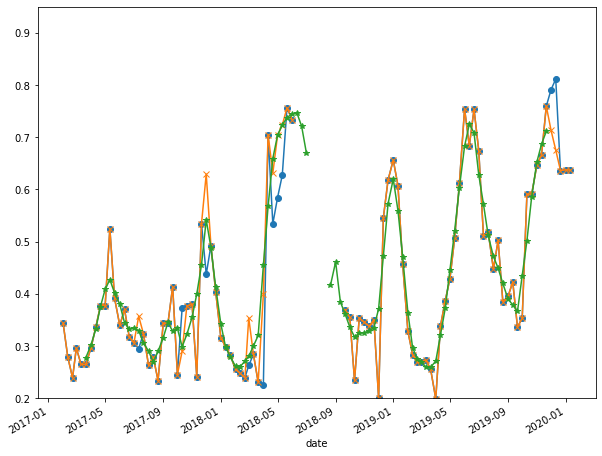

In [23]:
fig = plt.figure(figsize=(10,8))
ax = dfx.ndvi.plot(marker='o')

dfy.ndvi.plot(marker='x',ax=ax)
dfz.ndvi.plot(marker='*',ax=ax)

ax.set_ylim(0.2,0.95)
plt.show()

In [24]:
# !earthengine --no-use_cloud_api task list

In [25]:
def formatOutput(img):
    ndvi = img.select('ndvi').multiply(10000).int16()
    others = img.select('^(clima|de|pct|sp|tem).*').multiply(100).uint8()
    
    return ee.Image.cat([ndvi,others]).updateMask(landMask)\
        .set('system:time_start',img.date().millis())

landMask = ee.Image("users/kelmarkert/public/landMask").select("land")
outputs = smoothed.imageCollection.filterDate("2007-02-01","2007-03-21").map(formatOutput).sort('system:time_start') # eeIni.advance(9,'month'),eeEnd

In [26]:
exportAsset = "projects/servir-e-sa/rangelands/reNDVI"
exportRegion = ee.Geometry.Rectangle([33,-5,42,6],'epsg:4326',False)
metadataDict = dict(contact="kel.markert@nasa.gov",ndviScale=0.0001,otherScale=0.01,offset=0,version=0,creationDate=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%s"))
pyramidingDict = {'.default':"mean",'despiked':'mode','climatologyFilled':'mode','temporalFilled':'mode','spatialSmoothed':'mode'}

In [27]:
# rendvi.batchExport(outputs, 
#                    exportRegion, 
#                    exportAsset, 
#                    prefix="MOD_reNDVI", 
#                    suffix="v0", 
#                    scale=250, 
#                    crs='EPSG:4326',
#                    metadata=metadataDict, 
#                    pyramiding=pyramidingDict
#                   )